#### Imports, check that GPU is used

In [ ]:
! nvcc  --version
! pip install tensorflow keras --quiet
! pip install seaborn --quiet
! pip install kaggle --quiet

# needed for AugMix (removed)
# !pip install keras-cv --quiet

In [ ]:
# dataset
import shutil
import os

import pandas as pd
import collections

# model
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import optimizers

import keras_tuner as kt
# from keras_cv.layers import AugMix

# graphs/stats
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
#assert 'GPU' in str(device_lib.list_local_devices())
#assert len(tf.config.list_physical_devices('GPU')) > 0

tf.config.list_physical_devices('GPU')

### Dataset preparation

The dataset contains 2 folders
*   Infected
*   Parasitized
And a total of 27,558 images.
Acknowledgements
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/
And uploaded here, so anybody trying to start working with this dataset can get started immediately, as to download the
dataset from NIH website is quite slow.

1. kaggle automatic download
2. load and split the dataset in train/val (80/20) & getting label names
3. compute dataset statistics
4. dataset standardization
5. dataset augmentation

#### Download **Kaggle** *malaria NIH dataset*
You are required to load your personal Kaggle API keys (kaggle.json) into colab, then the NIH dataset will be downloaded directly from Kaggle

In [8]:
# make a kaggle directory, copy the loaded kaggle API key
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
# change r/w permissions
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/teamspace/studios/this_studio/.kaggle’: File exists


In [9]:
# remove the dataset folder if it exists
! rm -rf cell_images

# download the NIH malaria dataset directly from kaggle
! kaggle datasets download iarunava/cell-images-for-detecting-malaria
# optionally rename, unzip the downloaded dataset
# ! mv cell-images-for-detecting-malaria.zip dataset.zip
! unzip -qq cell-images-for-detecting-malaria.zip
! rm cell-images-for-detecting-malaria.zip

# the dataset contains a duplicated folder, to remove it:
! rm -rf ./cell_images/cell_images
# try:
#  shutil.rmtree('./cell_images/cell_images')
# except:
#   pass

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 87%|██████████████████████████████████▋     | 586M/675M [00:00<00:00, 1.02GB/s]
100%|████████████████████████████████████████| 675M/675M [00:00<00:00, 1.02GB/s]


#### Loading, splitting, standardizing the dataset and getting class names

In [10]:
# dataset folder
directory = "./cell_images"

filepath = []
label = []

folds = os.listdir(directory)

for fold in folds:
    f_path = os.path.join(directory, fold)
    imgs = os.listdir(f_path)
    for img in imgs:
        img_path = os.path.join(f_path, img)
        filepath.append(img_path)
        label.append(fold)

# Concatenate data paths with labels
file_path_series = pd.Series(filepath, name='filepath')
Label_path_series = pd.Series(label, name='label')
df_train = pd.concat([file_path_series, Label_path_series], axis=1)

In [11]:
# splitting the dataset and getting class names
img_height = 128
img_width = 128
batch_size = 32
SEED = 123 # for reproducibility

# training, test set split
# resizing already handled by TensorFlow
# no need to reshape

print('Loading and splitting the tf_dataset')
train_set, test_set = keras.utils.image_dataset_from_directory(
  directory,
  validation_split=0.2,  # 80/20%
  subset="both",
  # shuffle=False,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='binary'    # parasitized/uninfected
)

Loading and splitting the tf_dataset
Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


I0000 00:00:1747166294.570306    1993 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43629 MB memory:  -> device: 0, name: NVIDIA L40S, pci bus id: 0000:34:00.0, compute capability: 8.9


In [12]:
# getting the class names
classes = train_set.class_names
num_classes = len(classes)
print(f'[0={classes[0]}, 1={classes[1]}]')

[0=Parasitized, 1=Uninfected]


The images need to be standardized, so we use a lambda function to standardize them so that they have values in (0,1)

In [13]:
# train_set = train_set.map(lambda x, y: (x/255, y))
test_set = test_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 235.98145
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 238.88544
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 233.0232
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 238.07
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 237.45357


2025-05-13 19:58:16.419801: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Compute some dataset statistics

In [ ]:

# calculates how many images there are for each class
def num_img_per_class(dataset):
  class_counts = collections.Counter()
  for _, labels in dataset:
      class_indices = labels.numpy().squeeze().astype(int)  # (batch_size, 1) → (batch_size,)
      class_counts.update(map(int, class_indices))
  return class_counts

# Get counts
train_class_counts = num_img_per_class(train_set)
val_class_counts = num_img_per_class(test_set)
print('Training set:', train_class_counts)
print('Validation set:', val_class_counts)

In [ ]:
# bar diagram of training and validation classes distribution
labels_map = {0: 'Parasitized', 1: 'Uninfected'}

# Prepare data
x_labels = [labels_map[i] for i in sorted(labels_map.keys())]
x_pos = range(len(x_labels))
train_vals = [train_class_counts[i] for i in sorted(labels_map.keys())]
val_vals = [val_class_counts[i] for i in sorted(labels_map.keys())]

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(8, 6))

# Plot bars
bar_width = 0.35
bars1 = plt.bar([i - bar_width/2 for i in x_pos], train_vals, width=bar_width, label='Training', color='skyblue')
bars2 = plt.bar([i + bar_width/2 for i in x_pos], val_vals, width=bar_width, label='Test', color='orange')

# Add counts on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, f'{height}', ha='center', va='bottom', fontsize=9)

# Final touches
plt.xticks(ticks=x_pos, labels=x_labels)
plt.ylabel("Number of Images")
plt.title("Class Distribution in Training vs Test Set")
plt.legend()
plt.tight_layout()
plt.show()

As you can see the class distribution is almost identical both for the training set and test set.
We will now show some images

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy()).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()

#### Data augmentation (custom pipeline)

We will now extend (double) the training dataset by adding images obtained with various data augmentation techniques. The augmented dataset is merged with the training set to enalrge it. At last, the merged dataset is normalized.

In [14]:

# we have discovered that AugMix, which has great theoretical performances does not work well
# on our medical images as it introduces too many color variations, so we moved to a more
# conventional data augmentation pipeline
# AugMix(
#         severity=1,
#         chain_depth=1,
#         alpha=0.1,
#         value_range=(0, 255),
#     ),
# see https://arxiv.org/abs/1912.02781 for details on AugMix

preprocessing = keras.Sequential([
    # geometric transformations
    layers.RandomRotation(factor=0.2),
    layers.RandomFlip(mode='horizontal_and_vertical'),

    # illumination transformations
    layers.RandomBrightness(factor=0.15),
    layers.RandomContrast(factor=0.15),

    # some noise
    layers.GaussianNoise(stddev=0.05),
    #layers.Rescaling(1./255), # data standardization
])

augmented_dataset = train_set.map(lambda x, y: (preprocessing(x), y))
# concatenate the two datasets to form a big one
train_set = train_set.concatenate(augmented_dataset)

print('Augmented set size:', augmented_dataset.cardinality().numpy()*batch_size)
print('Merged set size:', train_set.cardinality().numpy()*batch_size)



Augmented set size: 22048
Merged set size: 44096


Now we standardize the training set as well as the merged dataset

In [15]:
train_set = train_set.map(lambda x, y: (x/255, y))

for image, _ in train_set.take(5):
    img = image.numpy()
    print("Image shape:", img.shape)
    print("Pixel value range: min =", img.min(), ", max =", img.max())

Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.90348643
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.90390867
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.909712
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9365962
Image shape: (32, 128, 128, 3)
Pixel value range: min = 0.0 , max = 0.9221766


2025-05-13 19:58:29.379623: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The images are preprocessed and standardized

/tmp/ipykernel_1993/2243483184.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(labels[i].numpy())], fontsize=6)


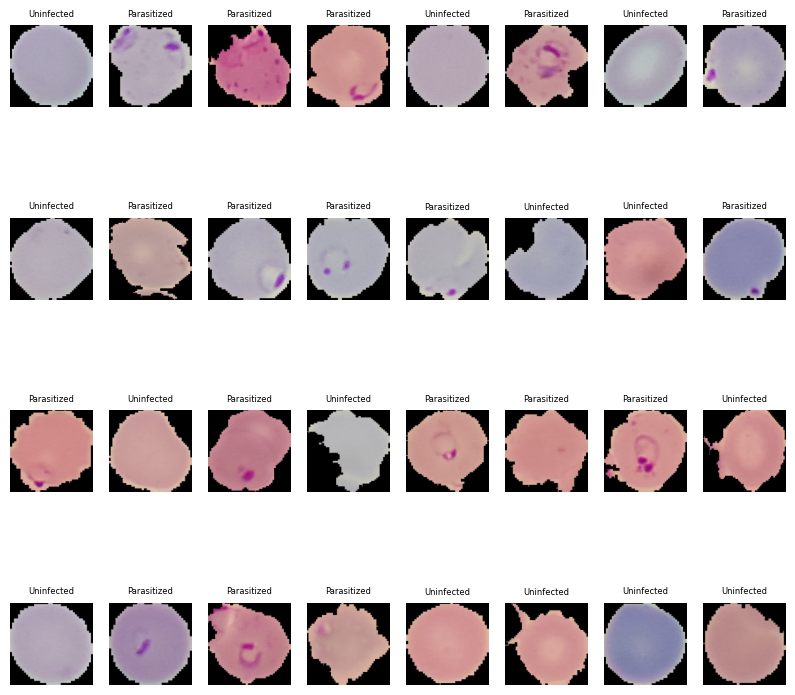

In [16]:
plt.figure(figsize=(10, 10))

for images, labels in train_set.take(1):
    num_images = batch_size  # Show more images
    for i in range(num_images):
        ax = plt.subplot(4, 8, i+1)  # 4x8 grid
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[int(labels[i].numpy())], fontsize=6)
        plt.axis("off")

plt.subplots_adjust(hspace=0)
plt.show()


As you can see the images are changed, we can finally apply some optimizations

In [17]:
# cache and prefetch for faster training
train_set = train_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Model selection using KerasTuner


1.   build the model
2.   select the best hyperparameters



In [29]:
def model_builder(hp):
    input_shape = (128, 128, 3) # Height, Width, Channels (RGB)
    hp_activation = hp.Choice('activation', values=['relu', 'leaky_relu', 'elu'])
    
    model = keras.Sequential()
    
    # block 1
    model.add(layers.Input(input_shape))
    model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c1_filter', min_value=16, max_value=128, step=8),
            strides=hp.Int('c1_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c1_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    """ model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c12_filter', min_value=16, max_value=128, step=8),
            strides=hp.Int('c12_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c12_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    ) """
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('drop_1', min_value=0.0, max_value=0.4, step=0.025)))


    # block 2
    model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c2_filter', min_value=32, max_value=256, step=16),
            strides=hp.Int('c2_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c2_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    """ model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c22_filter', min_value=32, max_value=256, step=16),
            strides=hp.Int('c22_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c22_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    ) """
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('drop_2', min_value=0.0, max_value=0.4, step=0.05)))

    # block 3
    model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c3_filter', min_value=64, max_value=256, step=32),
            strides=hp.Int('c3_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c3_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    )
    model.add(layers.BatchNormalization())
    """ model.add( 
        layers.SeparableConv2D(
            filters=hp.Int('c32_filter', min_value=64, max_value=256, step=32),
            strides=hp.Int('c32_strides', min_value=1, max_value=3),
            kernel_size=hp.Int('c32_kernel', min_value=3, max_value=5, step=2),
            activation=hp_activation,
            padding='same'
        )
    ) """
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(hp.Float('drop_3', min_value=0.0, max_value=0.4, step=0.025)))

    # Global Average Pooling
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layer
    model.add(
        layers.Dense(
            units=hp.Int('dense_units', min_value=128, max_value=512, step=32),
            activation=hp_activation
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(hp.Float('drop_4', min_value=0.0, max_value=0.5, step=0.025)))

    # Output Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    # defaults to Adam
    optimizer= keras.optimizers.Adam(learning_rate=0.01)
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    lrate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling='LOG')

    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=lrate,)
    elif optimizer_choice == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=lrate)
    elif optimizer_choice == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=lrate)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

    

In [31]:
# split train into train_reduced/val
train_size = int(train_set.cardinality().numpy() * 0.8)
train_reduced = train_set.take(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = train_set.skip(train_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# 3. Verify the split (Optional)
print("Reduced training dataset size:", train_reduced.cardinality().numpy()*batch_size)
print("Validation dataset size:", val_set.cardinality().numpy()*batch_size)

Reduced training dataset size: 35264
Validation dataset size: 8832


In [32]:
tuner = kt.Hyperband(
    hypermodel=model_builder,
    objective='val_accuracy',
    max_epochs=6,
    factor = 3,
    directory = 'tuned_models',
    project_name='malaria_det'
)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(train_reduced, epochs=100, validation_data=val_set, callbacks=[stop_early])

Trial 10 Complete [00h 01m 22s]
val_accuracy: 0.9400973916053772

Best val_accuracy So Far: 0.9514211416244507
Total elapsed time: 00h 06m 28s


In [33]:
# Get the best model
best_params = tuner.get_best_hyperparameters(num_trials=3)[0]

# create the best model found
best_model = tuner.hypermodel.build(best_params)
best_model.summary()

# retrain the best model on the entire training set
history = best_model.fit(train_set, epochs=50, callbacks=[stop_early])

# Evaluate it on the test set
loss, accuracy = best_model.evaluate(test_set, verbose=0)

print(f'Best model test loss: {loss:.4f}')
print(f'Best model test accuracy: {accuracy:.4f}')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d_3              │ (None, 64, 64, 112)    │           475 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 112)    │           448 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 112)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 32, 32, 224)    │        26,320 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 224)    │           896 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 224)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 16, 16, 256)    │        63,200 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 480)            │       123,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 480)            │         1,920 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,124 (852.05 KB)

 Trainable params: 215,980 (843.67 KB)

 Non-trainable params: 2,144 (8.38 KB)

Epoch 1/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.7104 - loss: 0.5593
Epoch 2/50
  37/1378 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9187 - loss: 0.2219

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9291 - loss: 0.2018
Epoch 3/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9418 - loss: 0.1697
Epoch 4/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9485 - loss: 0.1533
Epoch 5/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9526 - loss: 0.1422
Epoch 6/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9541 - loss: 0.1360
Epoch 7/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9570 - loss: 0.1287
Epoch 8/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9592 - loss: 0.1237
Epoch 9/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9593 - loss: 0.1207
Epoch 10/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9615 - loss: 0.1158
Epoch 11/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9607 - loss: 0.1140
Epoch 12/50
1378/1378 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9636 - loss: 0.1106
Epoch 13/50
1378/1378 ━━━━━━━━━━━━━━━━━━

2025-05-13 20:17:07.432029: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_149', 4 bytes spill stores, 4 bytes spill loads

2025-05-13 20:17:07.644989: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_149', 8 bytes spill stores, 8 bytes spill loads



Best model test loss: 0.1632
Best model test accuracy: 0.9601
